In [1]:
# September 2025
# Calculate similarity between positive titles and titles from repo
# Violeta Berdejo-Espinola & Ákos Hájas

In [2]:
# %pip install polars pyarrow

import polars as pl

In [3]:
# read data

df_repo = pl.read_csv('../data/outputs_pre-processing/repo_jap_pre-processed_year_range_ok.csv', encoding='utf8')
df_pos = pl.read_csv('../data/outputs_pre-processing/pos_jap_pre-processed.csv')

print(len(df_repo), len(df_pos))

df_repo = df_repo.unique(subset="title_en")
df_pos = df_pos.unique(subset="title_en")

len(df_repo), len(df_pos)

5278 307


(5278, 307)

In [4]:
# create list of pos titles and repo titles and title and abstract

pos_title = df_pos.select(
    pl.col("title_en").cast(pl.Utf8)
    )["title_en"].to_list()

repo_title = df_repo.select(
    pl.col('title_en').cast(pl.Utf8)
    )['title_en'].to_list()

len(repo_title), len(pos_title)

(5278, 307)

# compute similarity between titles

similarity threshold 0.9 - input: all titles

In [5]:
# check similarity 
# %time 21:53

from Levenshtein import ratio

# batch positive titles to reduce memory workload
BATCH_SIZE = 50

df_similarity = []

for i in range(0, len(pos_title), BATCH_SIZE):
    collect_similarity = {}

    # check similarity
    for title in pos_title[i:i+BATCH_SIZE]:
        collect_similarity[title] = [
            i for i, rt in enumerate(repo_title) 
            if ratio(title, rt) > 0.9
            ]
    
    print(f'batch {i} completed')
        
    # save to disk
    df = pl.DataFrame({
        'title': list(collect_similarity.keys()), 
        'similarity': list(collect_similarity.values())
        })
    
    df_similarity.append(df)
  
df_similarity = pl.concat(df_similarity, how="vertical")
len(df_similarity)

batch 0 completed
batch 50 completed
batch 100 completed
batch 150 completed
batch 200 completed
batch 250 completed
batch 300 completed


307

In [6]:
# flatten similarity lists --> labels

df_master = df_similarity.with_columns(
    label=pl.col("similarity")
    .list
    .len()
    )
print(len(df_master))
print(df_master['label'].value_counts())

df_master = df_master.explode('similarity')

len(df_master) # length increases as new rows are created for those titles with 1+ matches

# df_repo[316434]
df_master.head()

307
shape: (2, 2)
┌───────┬───────┐
│ label ┆ count │
│ ---   ┆ ---   │
│ u32   ┆ u32   │
╞═══════╪═══════╡
│ 1     ┆ 118   │
│ 0     ┆ 189   │
└───────┴───────┘


title,similarity,label
str,i64,u32
"""Restoration Effect of Topsoil …",null,0
"""Vegetation and Soil Restoratio…",3898,1
"""Difference of nest box use in …",null,0
"""Protection of endangered plant…",1220,1
"""Improvement of the head constr…",1631,1


# find similar instances across dfs


In [7]:
# find total matches: titles with one andfor titles with 1+
# %time 4:33

similarity_data_list = []

# loop through df_master 
for row_master in df_master.rows(named=True):
    similarity_master = row_master['similarity']
    title_master = row_master['title']

    # loop through repo titles with index
    for i, row_repo in enumerate(df_repo['title_en']):
        
        if i == similarity_master:
            print(f"Match found: {row_repo}")
            df_repo.with_columns(pos_similarity=similarity_master)
            
            similarity_data = {
                'position_in_repo':i,
                'similarity':similarity_master,
                'name_in_repo':row_repo,
                'name_in_pos':title_master,
                'label':1
            }
            
            similarity_data_list.append(similarity_data)

# create dataframe
matches_df = pl.DataFrame(similarity_data_list)

Match found: Vegetation and Soil Restoration Process by Grazing Control at Desertified Sandy Grassland in Semi-Arid Regions of Northeast China
Match found: Protection of endangered plants from sika deer herbivory using deer-proof fences in the Tanzawa Mountains, central Japan
Match found: Improvement of the head construction for a nature-oriented fishway and a release experiment using Yamame Oncorhynchus masou in the Oshino River
Match found: Evaluation of river restoration techniques using woody debris and boulders naturally generated from flood events
Match found: Effects of deer fences in the conservation of Erythronium japonicum
Match found: Influence of a Fagus crenata Plantation with Different Weeding Periods on the Consequent Stand Structure in Cold Region with Snowiall
Match found: Adaptive restoration of Nymphoides peltata populations in Lake Kasumigaura from the soil seed bank
Match found: A Case of Bank Protection with Palm Fiber Roll for Bare Slopes Revegetation on Dam Lake

In [8]:
print(f"articles in master: {len(df_master)}")

print(f"articles in pos matches {len(matches_df)}")

articles in master: 307
articles in pos matches 118


In [9]:
# check if titles are actually in repo using isin funtion

sim_is_in_repo = (matches_df.with_columns(
    pl.col('name_in_repo')
    .is_in(matches_df['name_in_pos'])
    .alias("exists_in_repo")
    )
)

sim_is_in_repo 

# readme
# articles ARE in repo. isin returns FALSE similarities as it is more strict with the similarity measure
# however, after inspection, these seemingly false actually are in repo. Title differences are spaces, or dahses, etc

position_in_repo,similarity,name_in_repo,name_in_pos,label,exists_in_repo
i64,i64,str,str,i64,bool
3898,3898,"""Vegetation and Soil Restoratio…","""Vegetation and Soil Restoratio…",1,false
1220,1220,"""Protection of endangered plant…","""Protection of endangered plant…",1,true
1631,1631,"""Improvement of the head constr…","""Improvement of the head constr…",1,false
230,230,"""Evaluation of river restoratio…","""Evaluation of river restoratio…",1,false
1914,1914,"""Effects of deer fences in the …","""Effects of deer fences in the …",1,true
…,…,…,…,…,…
1950,1950,"""Effects of Palaemon paucidens …","""Effects of Palaemon paucidens …",1,true
4005,4005,"""Relationship between Dwarf-bam…","""Relationship between Dwarf-bam…",1,true
1083,1083,"""On the growth of trees planted…","""On the growth of trees planted…",1,true


# unmatched rows

In [10]:
# create df

# filter rows in master that are not in pos matches
unmatched_pos =  df_master.filter(
    (~pl.col('title')
     .is_in(matches_df['name_in_pos']))
)

unmatched_pos = unmatched_pos.unique(subset="title")

print(len(unmatched_pos))
unmatched_pos

189


title,similarity,label
str,i64,u32
"""Kinds and effectiveness of art…",null,0
"""Restoration Effect of Topsoil …",null,0
"""Capture and Release of Gallicr…",null,0
"""BREEDING OF THE KENTISH PLOVER…",null,0
"""A case study for introduction …",null,0
…,…,…
"""Effects of egg replacement on …",null,0
"""Experimental community ecology…",null,0
"""Survey of the number of seals …",null,0


# join pos dfs

In [11]:
# add labels to positive instances

df_pos = df_pos.with_columns(
    pl.lit(1).alias('label')
)

# join repo to matches to retrieve abstracts

df_matches_join = matches_df.join(df_repo, left_on="name_in_repo", right_on="title_en", how="left")

print(len(df_matches_join))

# join matches to pos to have a complete pos df

df_pos_join = df_pos.join(df_matches_join, how="left", left_on="title_en", right_on="name_in_pos")

print(f"articles in df pos: {len(df_pos_join)}")

# coerce empty strings to null in complete pos df

df_pos_join = df_pos_join.with_columns(
    pl.when(pl.col(pl.String).str.len_chars() == 0)
    .then(None)
    .otherwise(pl.col(pl.String))
    .name.keep()
)

# coalesce abstract cols in complete pos df

df_pos_join = df_pos_join.with_columns(
    pl.coalesce('abstract_ja','abstract_ja_right').alias('abstract_ja')
)

print(f"empty cells in pos abstract jap: {df_pos_join['abstract_ja'].is_null().sum()}")
print(f"empty cells in pos label col: {df_pos_join['label'].is_null().sum()}")

# remove instances without abstract in japanese

df_pos_join = df_pos_join.filter(
    pl.col("abstract_ja") != "")

print(f"articles in df pos: {len(df_pos_join)}")

# subset pos df 

df_pos_join = df_pos_join.select(
    pl.col(['title_ja','title_en','abstract_ja','abstract_en','journal', 'year', 'language','label','exists_in_repo'])
)

print(f"empty cells in pos abstract jap: {df_pos_join['abstract_ja'].is_null().sum()}")

118
articles in df pos: 307
empty cells in pos abstract jap: 127
empty cells in pos label col: 0
articles in df pos: 180
empty cells in pos abstract jap: 0


# join repo - pos

In [12]:
print(f"articles in repo: {len(df_repo)}")
print(f"empty cells in repo japanese abstract: {print(df_repo['abstract_ja'].is_null().sum())}")

# join pos df to repo df

df_full_join = df_repo.join(df_pos_join, on="title_en", how='full')

# coalesce cols 

df_full_join = df_full_join.with_columns(
    pl.coalesce('title_ja','title_ja_right').alias('title_ja'),
    pl.coalesce('title_en','title_en_right').alias('title_en'),
    pl.coalesce('abstract_ja','abstract_ja_right').alias('abstract_ja'),
    pl.coalesce('abstract_en','abstract_en_right').alias('abstract_en'),
    pl.coalesce('journal','journal_right').alias('journal'),
    pl.coalesce('year', 'year_right').alias('year'),
    pl.coalesce('language','language_right').alias('language')
)

print(f"articles in join: {len(df_full_join)}")
print(f"empty cells in japanese abstract: {df_full_join['abstract_ja'].is_null().sum()}")

# subset df

df_full_join = df_full_join.select(
    pl.col(['title_ja','title_en','abstract_ja','abstract_en','journal', 'year','language','label','doi'])
)
# 5278+180

# add labels to negative instances in repo_full

df_full_join = df_full_join.with_columns(
    pl.when(pl.col("label") == 1)
    .then("label")
    .otherwise(0).alias("label")
)

df_full_join["label"].value_counts()

articles in repo: 5278
0
empty cells in repo japanese abstract: None
articles in join: 5382
empty cells in japanese abstract: 0


label,count
i32,u32
1,180
0,5202


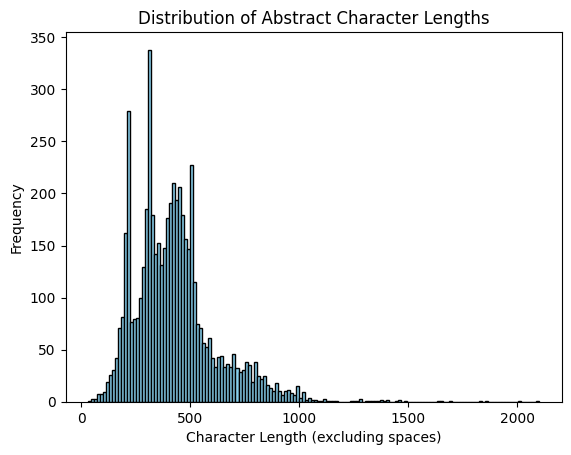

5382


In [13]:
import matplotlib.pyplot as plt

# Calculate character lengths excluding spaces
char_lens = [len(abstract.replace(" ", "")) for abstract in df_full_join['abstract_ja']]

# Plot the histogram
plt.hist(char_lens, bins=150, color='skyblue', edgecolor='black')
plt.xlabel('Character Length (excluding spaces)')
plt.ylabel('Frequency')
plt.title('Distribution of Abstract Character Lengths')
plt.show()
print(len(df_full_join))

In [14]:
# # remove instances with an abstract shorter than 300 characters

# repo_and_matches = repo_and_matches.with_columns(
#     pl.col("abstract")
#     .str.len_chars()
#     .alias("abstract_length")
# )

# repo_and_matches = repo_and_matches.filter(
#     pl.col("abstract_length") >= 300
# )

# print(len(repo_and_matches))

In [15]:
df_pos_join.head()

title_ja,title_en,abstract_ja,abstract_en,journal,year,language,label,exists_in_repo
str,str,str,str,str,i64,str,i32,bool
"""中国北東部半乾燥地域の砂地草原における放牧管理による植生・土…","""Vegetation and Soil Restoratio…","""過放牧による砂漠化が問題となっている中国内蒙古自治区奈曼を事…","""The process of vegetation and …","""Journal of The Japanese Instit…",1997,"""ja""",1,false
"""丹沢山地における植生保護柵による希少植物のシカ採食からの保護…","""Protection of endangered plant…","""ニホンジカの採食圧により林床植生が衰退した丹沢山地冷温帯の3…","""Four years after establishment…","""Japanese Journal of Conservati…",2005,"""ja""",1,true
"""群馬県押野川における落差工の多自然型魚道への改善とヤマメOn…","""Improvement of the head constr…","""大きな高低差のある落差工は,魚類が遡上できないなどの問題を生…","""High head constructions become…","""Ecology and Civil Engineering""",2000,"""ja""",1,false
"""アカネズミ(Apodemus speciosus)の自然交配…","""Rearing method to induce tura…","""飼育下でアカネズミ(Apodemus speciosus)の…",null,"""Mammalian Science""",2013,"""ja""",1,false
"""洪水により発生した倒流木と巨石を用いた河川再生工法の評価""","""Evaluation of river restoratio…","""荒廃渓流であった北海道北部パンケオロピリカイ川に設置された構…","""A stream that was severely dam…","""Ecology and Civil Engineering""",2011,"""ja""",1,false


In [16]:
df_full_join.head()

title_ja,title_en,abstract_ja,abstract_en,journal,year,language,label,doi
str,str,str,str,str,i64,str,i32,str
"""スギ雄花形成の機構解明と抑制技術""","""Formation of Cryptomeria japon…","""スギは我が国を代表する林業樹種である。しかし, スギ花粉症患…","""Cryptomeria japonica D. Don is…","""Journal of the Japanese Forest…",2010,"""ja""",0,"""doi.org/10.4005/jjfs.92.304"""
"""アンスラセンによるヒノキ人工林の相対照度の測定""","""Evaluation of the Light Climat…","""アンスラセンの光化学反砿を利用し,照度を積算量としてとらえ,…","""An anthracene-ethyl alcohol ch…","""Journal of the Japanese Forest…",1982,"""ja""",0,"""doi.org/10.11519/jjfs1953.64.6…"
"""道路法面上の樹林の面積とマツカレハ (Dendrolimus…","""Density-area relationship of t…","""東名高速道路,浜松・浜松西間の南面法面上に600m2のコード…","""Twelve quardrats, 40×15m were …","""Journal of the Japanese Forest…",1985,"""ja""",0,"""doi.org/10.11519/jjfs1953.67.2…"
"""ケヤキ街路樹の根系生長が歩道に与える影響""","""Study on the Influence on the …","""明治神宮表参道の帯状植枡に植栽されたケヤキ大径木の街路樹16…","""A Survey of the influence on t…","""Journal of the Japanese Instit…",1995,"""ja""",0,"""doi.org/10.5632/jila.59.5_49"""
"""ホルモン処理したヒノキさし穂の呼吸量の経時的変化""","""Effect of Auxins on Respiratio…","""ホルモン処理したヒノキさし穂の呼吸様式をしらべた。 1. 無…","""Effect of auxins on the rate o…","""Journal of the Japanese Forest…",1974,"""ja""",0,"""doi.org/10.11519/jjfs1953.56.4…"


In [17]:
# # save to disk

df_pos_join.write_parquet('../data/outputs_similarity_matches/pos_jap.parquet')
df_pos_join.write_csv('../data/outputs_similarity_matches/pos_jap.csv')
matches_df.write_parquet('../data/outputs_similarity_matches/pos_jap_matches.parquet')
matches_df.write_csv('../data/outputs_similarity_matches/pos_jap_matches.csv')
unmatched_pos.write_parquet('../data/outputs_similarity_matches/pos_jap_unmatched.parquet')
unmatched_pos.write_csv('../data/outputs_similarity_matches/pos_jap_unmatched.csv')

df_full_join.write_parquet('../data/outputs_similarity_matches/corpus_jap.parquet')
df_full_join.write_csv('../data/outputs_similarity_matches/corpus_jap.csv')

In [18]:
len(df_full_join), len(df_pos_join)

(5382, 180)